In [43]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import jieba
import nltk
from nltk.corpus import stopwords
import re

# Download English stopwords if needed
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))

#load in Chinese stopwords
zh_stopwords = set(open('chinese_stopwords.txt', encoding='utf-8').read().split())

# Load CSVs
df_cn = pd.read_csv('combined_output.csv')
df_en = pd.read_csv('imdb_combined_output.csv')

# Preview
print(df_cn.head())
print(df_en.head())

# Chinese preprocessing
def clean_chinese(text):
    text = re.sub(r"[^\u4e00-\u9fa5]", "", str(text))  # Keep only Chinese
    words = jieba.lcut(text)
    words = [word for word in words if word not in zh_stopwords]
    return ' '.join(words)

# English preprocessing
def clean_english(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = [w for w in text.split() if w not in eng_stopwords]
    return ' '.join(words)

# Apply preprocessing
df_cn['clean_comment'] = df_cn['review_text'].apply(clean_chinese)
df_en['clean_comment'] = df_en['comment'].apply(clean_english)

# Combine for joint clustering
df_cn['lang'] = 'zh'
df_en['lang'] = 'en'
df_all = pd.concat([df_cn, df_en], ignore_index=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elimarx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                       title  \
0  Spider-Man: Far From Home   
1  Spider-Man: Far From Home   
2  Spider-Man: Far From Home   
3  Spider-Man: Far From Home   
4  Spider-Man: Far From Home   

                                         review_text  stars  \
0  ÊàëÊòØ‰∏Ä‰∏™94Âπ¥ÁöÑÂπø‰∏ú‰∫∫ÔºåÊàë‰ªéÂ∞èË∫´ËæπÂÖÖÊñ•ÁùÄÂêÑÁßçËúòËõõ‰æ†‰ΩúÂìÅÔºåÊØèÂ§©Âçà‰ºëÂõûÂÆ∂ÂêÉÈ•≠Êúâ94ÁâàËúòËõõ‰æ†Âä®Áîª„ÄÇ...      1   
1  ÁúãÂÆåÂêéÁöÑÊÑüËßâÂíåÁúãÂâçÊãÖÂøÉÁöÑ‰∏ÄÊ†∑ÔºåÂ§™Ëøá‰∫é‰æùËµñ‰∫éMCU‰ª•Ëá≥‰∫éÂèòÊàê‰∫Ü‰∏ÄÈÉ®ÊúÄ‰∏çËúòËõõ‰æ†ÁöÑËúòËõõ‰æ†ÁîµÂΩ±„ÄÇÊàëÂØπ...      1   
2  ÁúãÂæóÁúüÁöÑÂæàÈöæÂèóÔºå‰∏çÊòØÂõ†‰∏∫ÂâßÊÉÖËÄåÊòØÂõ†‰∏∫ÊÉÖÊÄÄ„ÄÇÂΩìÂπ¥ÁöÑÈÇ£‰∏™‚ÄúËÉΩÂäõË∂äÂ§ßÔºåË¥£‰ªªË∂äÂ§ß‚ÄùÁöÑËúòËõõ‰æ†‰ªÄ‰πàÊó∂ÂÄôËÉΩ...      1   
3  ËøôÊòØÊàëÁúãËøáÊúÄÂ∑ÆÁöÑËúòËõõ‰æ†ÁîµÂΩ±ÔºåÁÆÄÁõ¥Â∞±ÊòØÈí¢ÈìÅ‰æ†2.0ÔºåËøô‰∏çÊòØÊàë‰ªéÂ∞èÊúÄÂñúÊ¨¢ÁöÑÈÇ£‰∏™Ë∂ÖÁ∫ßËã±ÈõÑÔºåÊàëÂ∏åÊúõÁöÑ...      1   
4  ÂÆåÂÖ®ÂÉèÊòØÂú®ËøáÂÆ∂ÂÆ∂ÔºåÊ†πÊú¨Ê≤°Êúâ‰∏Ä‰∏ÅÁÇπË∂ÖÁ∫ßËã±ÈõÑÁöÑÂΩ±Â≠ê„ÄÇ‰∫∫ÂÆ∂Âè™ÊÉ≥Ë∞àÊÅãÁà±Âï¶Ôºå‰∫∫ÂÆ∂Âè™ÊÉ≥Ë°®ÁôΩÂï¶ÔºåÊãØÊïë‰∏ñÁïå‰ªÄ...

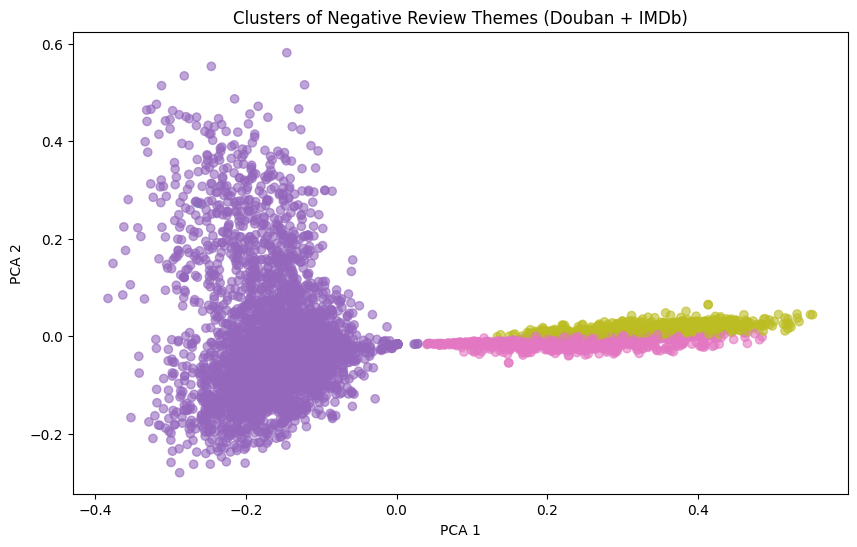

In [45]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_all['clean_comment'])

# Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df_all['cluster'] = kmeans.fit_predict(X)

# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df_all['cluster'], cmap='tab10', alpha=0.6)
plt.title("Clusters of Negative Review Themes (Douban + IMDb)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

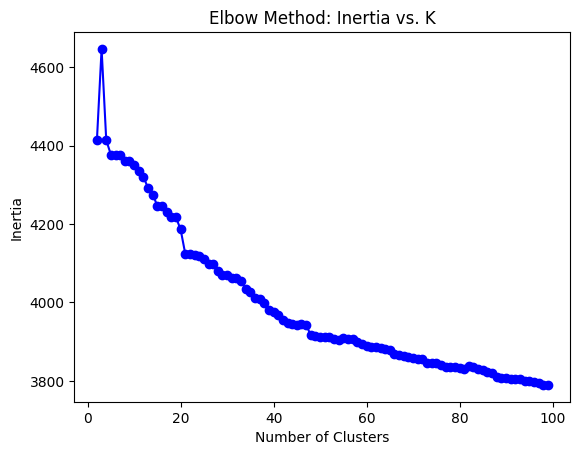

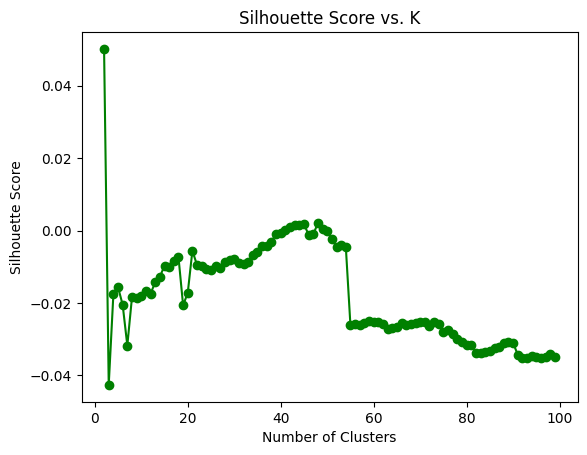

In [48]:
# Elbow plot to choose k
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K = range(2, 100)

for k in K:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X)
    inertias.append(kmeans_test.inertia_)
    silhouettes.append(silhouette_score(X, kmeans_test.labels_))

plt.plot(K, inertias, 'bo-')
plt.title("Elbow Method: Inertia vs. K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

plt.plot(K, silhouettes, 'go-')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [46]:
df_all['cluster'].value_counts()

cluster
2    3078
3     953
4     869
5       1
0       1
1       1
Name: count, dtype: int64

In [47]:
# Show sample reviews from each cluster
for cluster_id in sorted(df_all['cluster'].unique()):
    print(f"\nüîπ Cluster {cluster_id} ({df_all[df_all['cluster'] == cluster_id]['lang'].value_counts().to_dict()})")
    samples = df_all[df_all['cluster'] == cluster_id].sample(1, random_state=cluster_id)
    for _, row in samples.iterrows():
        print(f"  [{row['lang']}] {row['clean_comment'][:100]}...")


üîπ Cluster 0 ({'zh': 1})
  [zh] Êú¨Êù• ÊÉ≥ÁùÄ ‰∏äÊù• Áõ¥Êé• ‰ΩéÂàÜ Á§ºË≤å ÂÖà Êêú ‰∏Ä‰∏ã ÈïøÂüé ËØÑÂàÜ ÊØïÁ´ü ËßÇÂΩ± ‰πãÂâç Âèò ÈïøÂüé ‰πãÈó¥ Â∑Æ ÊôØÁîú Ê≤°ÊÉ≥Âà∞ Â∑ÆÂÄº Ë¥ü ÂØπ‰∏çËµ∑ Âè™ËÉΩ ÊØ´Êó†ÂøåÊÉÆ ÁõÆÂÖâÁü≠ÊµÖ ÁîµÂΩ± ÁúãÂæó Â∞ë‰π¶ ËØª Â∞ë ‰ª•‰∏ã ‰ªÖ‰∏∫ ‰∏™‰∫∫...

üîπ Cluster 1 ({'en': 1})
  [en] favorite academy award year really whats special movie theres plot movie boring confusing slowtheres...

üîπ Cluster 2 ({'zh': 3069, 'en': 9})
  [zh] ‰∏ÄÈ¢ó ÊòüÊòØ ÂçÅ‰∏ÄÂπ¥ ÊÉÖÊÄÄ ÁΩóÁ¥† ÂÖÑÂºü ÁºñÂâß Âõ¢Èòü ÁúüÁöÑ Èî§Âì• ÈòüÈïø ÁúüÁöÑ ÈùûË¶Å ÈÄÄ‰ºë ÂÜô ÈìÅ‰∫∫ ÊúÄÂ•Ω ÂØ°Âßê ÁªìÂ±Ä ÂêäÊâì ÈòøÁÅ≠ ÊÉäÂ•á ÈòüÈïø ËøôÁÇπ ËÉΩËÄê ‰∏ÄÁæ§ ÈùûÂæó Á©∫‰∏≠ Êé•Âäõ Ê≥ïÂ∏à ÊòéÊòé ÂºÄ ‰º†ÈÄÅÈó® Êòé...

üîπ Cluster 3 ({'en': 953})
  [en] keep book plot characters background mind heart leave story film doesnt follow book anyway character...

üîπ Cluster 4 ({'en': 869})
  [en] jurassic park tension story established like runaway train two adults two kids movie held breathtaki...

üîπ Cluster 5 ({'zh